### 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit,train_test_split
from sklearn.preprocessing import Imputer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
    
%matplotlib inline

import seaborn as sns
color = sns.color_palette()
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)

C:\Users\auvidiyasr\AppData\Local\Continuum\Anaconda3\envs\MachineLearningPy35\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### 2. User Defined functions

Function to compute and plot Precision-Recall curve

In [2]:
# Referenced from http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
# Compute Precision-Recall and plot curve
def plot_precision_recall(y_val, y_pred):
    n_classes=2
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_val, y_pred)
        average_precision[i] = average_precision_score(y_val, y_pred)

    # Compute micro-average ROC curve and ROC area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_val.ravel(),y_pred.ravel())
    average_precision["micro"] = average_precision_score(y_val, y_pred, average="micro")

    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall[0], precision[0], lw=2, color='navy',
         label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
    plt.legend(loc="lower left")
    plt.show()

Function to plot histogram

In [3]:
def plot_hist(index,data,xlab,title):
    pos = np.arange(data.shape[0]) + 1
    sns.barplot(index,data, color=color[0])
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(xlab, fontsize='small', verticalalignment='bottom',horizontalalignment='center')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.autoscale()
    plt.show()

Function to plot the confusion matrix

In [4]:
def plot_confusion_matrix(y_true, y_pred):
    sub = pd.concat([y_val.reset_index(drop=True),pd.DataFrame(y_pred)],axis=1)
    sub.columns = ['y_true','y_pred']
    sub.head()
    sub.replace(0.0,'<=50K', inplace=True)
    sub.replace(1,'>50K', inplace=True)
    cnf_matrix = pd.crosstab(sub.iloc[:,0], sub.iloc[:,1], rownames=['Actual'], colnames=['Predicted'])
    print("Confusion Matrix")
    print("###################")
    print(cnf_matrix)
    print("###################")

### Reading data from file

In [6]:
data = pd.read_csv("adult_data.csv",header=None, error_bad_lines=True,skipinitialspace=True)

Setting the column names to the data

In [7]:
data.columns = ["age", "type_employer", "fnlwgt", "education", 
                "education_num","marital", "occupation", "relationship", "race","sex",
                "capital_gain", "capital_loss", "hr_per_week","country", "income"]
data.head()

age     type_employer  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

              marital         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hr_per_week        country income  
0          2174             0           40  United-States  <=50K  
1             0             0           13  United-States  <=50K  
2             0             0           40  United-States  <=50K  
3             0             0           40  United-States  <=50K  
4             0             0           40           Cuba  <=50K

In [8]:
data.describe()

age        fnlwgt  education_num  capital_gain  capital_loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

        hr_per_week  
count  32561.000000  
mean      40.437456  
std       12.347429  
min        1.000000  
25%       40.000000  
50%       40.000000  
75%       45.000000  
max       99.000000

Replace the '?' with NA values

In [11]:
data.replace('?',np.nan,inplace=True)

In [12]:
data.isnull().sum()

age                 0
type_employer    1836
fnlwgt              0
education           0
education_num       0
marital             0
occupation       1843
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hr_per_week         0
country           583
income              0
dtype: int64

The variables "type_employer", "occupation" and "country" contain missing data.

In [13]:
inc= data.income.value_counts()

Plot the target variable to check for class imbalance

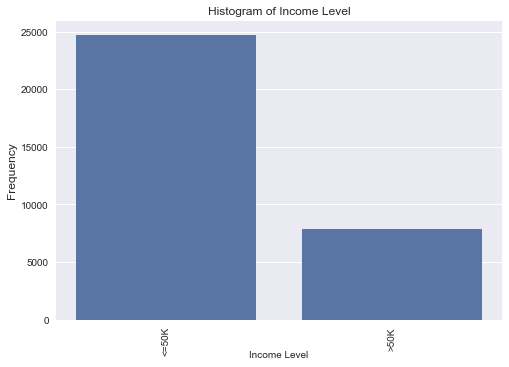

In [21]:
plot_hist(inc.index, inc, 'Income Level', 'Histogram of Income Level')

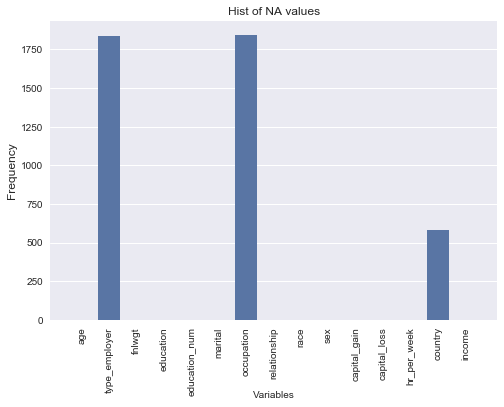

In [15]:
plot_hist(data.isnull().sum().index, data.isnull().sum(),"Variables","Hist of NA values")

In [16]:
data['type_employer'] = pd.factorize(data.type_employer)[0]
data['marital'] = pd.factorize(data.marital)[0]
data['occupation'] = pd.factorize(data.occupation)[0]
data['relationship'] = pd.factorize(data.relationship)[0]
data['race'] = pd.factorize(data.race)[0]
data['sex'] = pd.factorize(data.sex)[0]
data['country'] = pd.factorize(data.country)[0]
data['income_labels'] = pd.factorize(data.income)[0]
data.replace(-1,np.nan,inplace=True)

In [17]:
del data['education']

In [18]:
label_dict = {'<=50K':0,'>50K':1}

In [19]:
del data['income']

In [20]:
data.head()

age  type_employer  fnlwgt  education_num  marital  occupation  \
0   39            0.0   77516             13        0         0.0   
1   50            1.0   83311             13        1         1.0   
2   38            2.0  215646              9        2         2.0   
3   53            2.0  234721              7        1         2.0   
4   28            2.0  338409             13        1         3.0   

   relationship  race  sex  capital_gain  capital_loss  hr_per_week  country  \
0             0     0    0          2174             0           40      0.0   
1             1     0    0             0             0           13      0.0   
2             0     0    0             0             0           40      0.0   
3             1     1    0             0             0           40      0.0   
4             2     1    1             0             0           40      1.0   

   income_labels  
0              0  
1              0  
2              0  
3              0  
4              0

### Impute Missing Values

In [22]:
imr = Imputer(missing_values='NaN', strategy='median', axis=0)
imr = imr.fit(data)
imputed_data = pd.DataFrame(imr.transform(data.values))

In [23]:
imputed_data.shape

(32561, 14)

In [24]:
imputed_data.columns = data.columns
imputed_data.head()

age  type_employer    fnlwgt  education_num  marital  occupation  \
0  39.0            0.0   77516.0           13.0      0.0         0.0   
1  50.0            1.0   83311.0           13.0      1.0         1.0   
2  38.0            2.0  215646.0            9.0      2.0         2.0   
3  53.0            2.0  234721.0            7.0      1.0         2.0   
4  28.0            2.0  338409.0           13.0      1.0         3.0   

   relationship  race  sex  capital_gain  capital_loss  hr_per_week  country  \
0           0.0   0.0  0.0        2174.0           0.0         40.0      0.0   
1           1.0   0.0  0.0           0.0           0.0         13.0      0.0   
2           0.0   0.0  0.0           0.0           0.0         40.0      0.0   
3           1.0   1.0  0.0           0.0           0.0         40.0      0.0   
4           2.0   1.0  1.0           0.0           0.0         40.0      1.0   

   income_labels  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [25]:
features = imputed_data.iloc[:,:-1]
target = imputed_data.iloc[:,-1]

In [26]:
features.columns

Index(['age', 'type_employer', 'fnlwgt', 'education_num', 'marital',
       'occupation', 'relationship', 'race', 'sex', 'capital_gain',
       'capital_loss', 'hr_per_week', 'country'],
      dtype='object')

In [27]:
features.head()

age  type_employer    fnlwgt  education_num  marital  occupation  \
0  39.0            0.0   77516.0           13.0      0.0         0.0   
1  50.0            1.0   83311.0           13.0      1.0         1.0   
2  38.0            2.0  215646.0            9.0      2.0         2.0   
3  53.0            2.0  234721.0            7.0      1.0         2.0   
4  28.0            2.0  338409.0           13.0      1.0         3.0   

   relationship  race  sex  capital_gain  capital_loss  hr_per_week  country  
0           0.0   0.0  0.0        2174.0           0.0         40.0      0.0  
1           1.0   0.0  0.0           0.0           0.0         13.0      0.0  
2           0.0   0.0  0.0           0.0           0.0         40.0      0.0  
3           1.0   1.0  0.0           0.0           0.0         40.0      0.0  
4           2.0   1.0  1.0           0.0           0.0         40.0      1.0

In [28]:
features.isnull().sum()

age              0
type_employer    0
fnlwgt           0
education_num    0
marital          0
occupation       0
relationship     0
race             0
sex              0
capital_gain     0
capital_loss     0
hr_per_week      0
country          0
dtype: int64

### Split the data into training and validation 

In [29]:
X_trn, X_val, y_trn, y_val = train_test_split(features, target, random_state=13)

In [44]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

### Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
#without minmax scaling
# instantiate
logreg = LogisticRegression(C=10,fit_intercept=True, penalty='l2', solver='lbfgs', max_iter=10000)

# fit
logreg.fit(X_trn, y_trn.values.ravel().T)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
cross_val_score(logreg, X_trn, y_trn.values.ravel().T, cv=cv).mean()

0.79688779688779698

In [47]:
# predict
y_pred = logreg.predict(X_val)

print('LogReg accuracy %s' % metrics.accuracy_score(y_val, y_pred))
print('LogReg precision %s' % metrics.precision_score(y_val, y_pred))
print('LogReg recall %s' % metrics.recall_score(y_val, y_pred))
print('LogReg f1 score %s' % metrics.f1_score(y_val, y_pred))
print('\n')
print('LogReg classification report')
print(metrics.classification_report(y_val, y_pred))

LogReg accuracy 0.801989927527
LogReg precision 0.726123595506
LogReg recall 0.267321613237
LogReg f1 score 0.390778533636


LogReg classification report
             precision    recall  f1-score   support

        0.0       0.81      0.97      0.88      6207
        1.0       0.73      0.27      0.39      1934

avg / total       0.79      0.80      0.77      8141



In [48]:
plot_confusion_matrix(y_val, y_pred)

Confusion Matrix
###################
Predicted  <=50K  >50K
Actual                
<=50K       6012   195
>50K        1417   517
###################


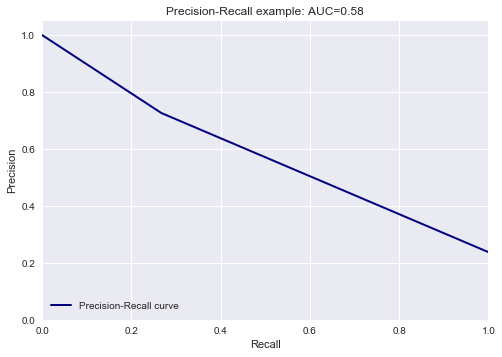

In [49]:
plot_precision_recall(y_val, y_pred)

### Min Max scaling for logistic regression

In [50]:
X_std=(X_trn - X_trn.min(axis=0)) / (X_trn.max(axis=0) - X_trn.min(axis=0))
X_std_val = (X_val - X_val.min(axis=0)) / (X_val.max(axis=0) - X_val.min(axis=0))

In [51]:
X_std.describe()

age  type_employer        fnlwgt  education_num       marital  \
count  24420.000000   24420.000000  24420.000000   24420.000000  24420.000000   
mean       0.294808       0.300456      0.120815       0.605026      0.180699   
std        0.186297       0.130066      0.071836       0.171544      0.208176   
min        0.000000       0.000000      0.000000       0.000000      0.000000   
25%        0.150685       0.285714      0.071772       0.533333      0.000000   
50%        0.273973       0.285714      0.112964       0.600000      0.166667   
75%        0.410959       0.285714      0.153265       0.733333      0.166667   
max        1.000000       1.000000      1.000000       1.000000      1.000000   

         occupation  relationship          race           sex  capital_gain  \
count  24420.000000  24420.000000  24420.000000  24420.000000  24420.000000   
mean       0.326671      0.307674      0.055723      0.332883      0.010564   
std        0.227210      0.286791      0.157694      0.471255      0.072866   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.153846      0.000000      0.000000      0.000000      0.000000   
50%        0.307692      0.200000      0.000000      0.000000      0.000000   
75%        0.461538      0.600000      0.000000      1.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       capital_loss   hr_per_week       country  
count  24420.000000  24420.000000  24420.000000  
mean       0.020453      0.402312      0.028547  
std        0.093524      0.125862      0.120442  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.397959      0.000000  
50%        0.000000      0.397959      0.000000  
75%        0.000000      0.448980      0.000000  
max        1.000000      1.000000      1.000000

In [60]:
from sklearn.linear_model import LogisticRegression
#with minmax scaling
# instantiate
logreg = LogisticRegression(C=10,fit_intercept=True, penalty='l2', solver='lbfgs', max_iter=10000)

# fit
logreg.fit(X_std, y_trn.values.ravel().T)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
cross_val_score(logreg, X_std, y_trn.values.ravel().T, cv=cv).mean()

0.82684957684957683

In [62]:
# predict
y_pred = logreg.predict(X_std_val)

print('LogReg accuracy %s' % metrics.accuracy_score(y_val, y_pred))
print('LogReg precision %s' % metrics.precision_score(y_val, y_pred))
print('LogReg recall %s' % metrics.recall_score(y_val, y_pred))
print('LogReg f1 score %s' % metrics.f1_score(y_val, y_pred))
print('\n')
print('LogReg classification report')
print(metrics.classification_report(y_val, y_pred))

LogReg accuracy 0.827416779265
LogReg precision 0.705516705517
LogReg recall 0.46949327818
LogReg f1 score 0.563800062093


LogReg classification report
             precision    recall  f1-score   support

        0.0       0.85      0.94      0.89      6207
        1.0       0.71      0.47      0.56      1934

avg / total       0.82      0.83      0.81      8141



In [63]:
plot_confusion_matrix(y_val, y_pred)

Confusion Matrix
###################
Predicted  <=50K  >50K
Actual                
<=50K       5828   379
>50K        1026   908
###################


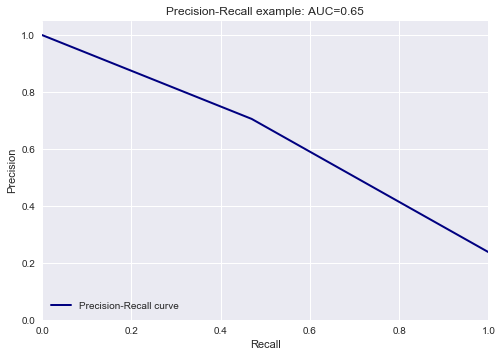

In [64]:
plot_precision_recall(y_val, y_pred)

### Standard Scaling for Logistic Regression

In [65]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_trn)
X_trn_std = sc.transform(X_trn)
X_val_std = sc.transform(X_val)

In [66]:
from sklearn.linear_model import LogisticRegression
#with standard scaling
# instantiate
logreg = LogisticRegression(C=10,fit_intercept=True, penalty='l2', solver='lbfgs', max_iter=1000)

# fit
logreg.fit(X_trn_std, y_trn.values.ravel().T)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [67]:
cross_val_score(logreg, X_trn_std, y_trn.values.ravel().T, cv=cv).mean()

0.82660387660387669

In [68]:
# predict
y_pred = logreg.predict(X_val_std)

print(metrics.classification_report(y_val, y_pred))
print('LogReg accuracy %s' % metrics.accuracy_score(y_val, y_pred))
print('LogReg precision %s' % metrics.precision_score(y_val, y_pred))
print('LogReg recall %s' % metrics.recall_score(y_val, y_pred))
print('LogReg f1 score %s' % metrics.f1_score(y_val, y_pred))

             precision    recall  f1-score   support

        0.0       0.85      0.94      0.89      6207
        1.0       0.70      0.46      0.56      1934

avg / total       0.81      0.83      0.81      8141

LogReg accuracy 0.825819923842
LogReg precision 0.70251177394
LogReg recall 0.462771458118
LogReg f1 score 0.557980049875


In [69]:
plot_confusion_matrix(y_val, y_pred)

Confusion Matrix
###################
Predicted  <=50K  >50K
Actual                
<=50K       5828   379
>50K        1039   895
###################


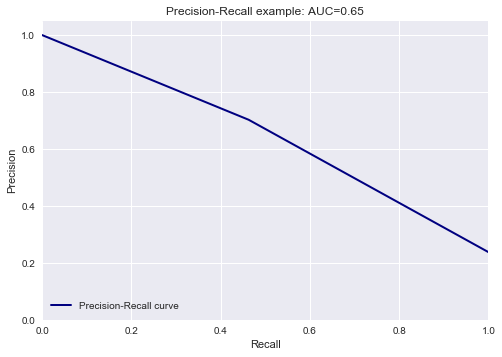

In [70]:
plot_precision_recall(y_val, y_pred)

### Random Forests

In [71]:
from sklearn.ensemble import RandomForestClassifier
rfclsf = RandomForestClassifier()
rfclsf.fit(X_trn,y_trn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [72]:
y_hat_rf = rfclsf.predict(X_val)

In [73]:
print(metrics.classification_report(y_val, y_hat_rf))
print('RF accuracy %s' % metrics.accuracy_score(y_val, y_hat_rf))
print('RF precision %s' % metrics.precision_score(y_val, y_hat_rf))
print('RF recall %s' % metrics.recall_score(y_val, y_hat_rf))
print('RF f1 score %s' % metrics.f1_score(y_val, y_hat_rf))

             precision    recall  f1-score   support

        0.0       0.88      0.93      0.90      6207
        1.0       0.72      0.57      0.64      1934

avg / total       0.84      0.84      0.84      8141

RF accuracy 0.844736518855
RF precision 0.715850515464
RF recall 0.574457083764
RF f1 score 0.637406769937


In [74]:
plot_confusion_matrix(y_val, y_hat_rf)

Confusion Matrix
###################
Predicted  <=50K  >50K
Actual                
<=50K       5766   441
>50K         823  1111
###################


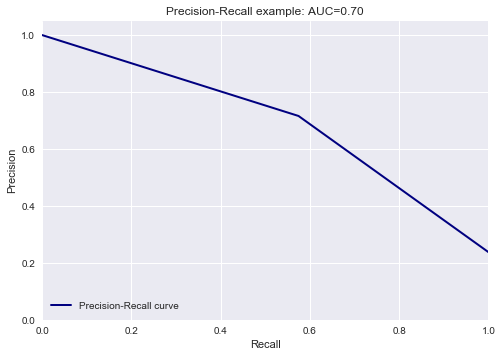

In [75]:
plot_precision_recall(y_val,y_hat_rf)

### Random Forest with OOB Score

In [77]:
rndmcForClsf = RandomForestClassifier(n_estimators=500, criterion='gini',bootstrap=True, 
                                      oob_score=True, random_state=1, warm_start=True)
rndmcForClsf.fit(X_trn, y_trn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=True)

In [78]:
y_pred_rf = rndmcForClsf.predict(X_val)

In [79]:
print(metrics.classification_report(y_val, y_pred_rf))
print('RF accuracy %s' % metrics.accuracy_score(y_val, y_pred_rf))
print('RF precision %s' % metrics.precision_score(y_val, y_pred_rf))
print('RF recall %s' % metrics.recall_score(y_val, y_pred_rf))
print('RF f1 score %s' % metrics.f1_score(y_val, y_pred_rf))

             precision    recall  f1-score   support

        0.0       0.89      0.93      0.91      6207
        1.0       0.74      0.63      0.68      1934

avg / total       0.85      0.86      0.85      8141

RF accuracy 0.858616877533
RF precision 0.738865161684
RF recall 0.626163391934
RF f1 score 0.677861740834


In [80]:
plot_confusion_matrix(y_val, y_pred_rf)

Confusion Matrix
###################
Predicted  <=50K  >50K
Actual                
<=50K       5779   428
>50K         723  1211
###################


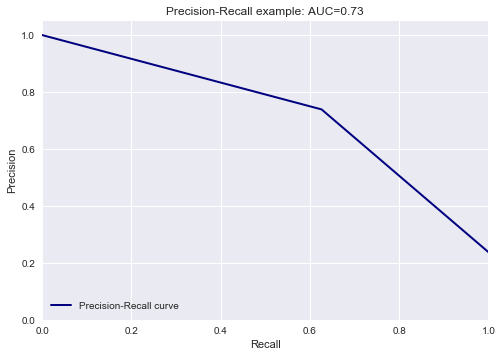

In [81]:
plot_precision_recall(y_val,y_pred_rf)

### Random Forest with OOB and minmax scaling

In [83]:
rndmcForClsf = RandomForestClassifier(n_estimators=500, criterion='gini',bootstrap=True, 
                                      oob_score=True, random_state=1, warm_start=True)
rndmcForClsf.fit(X_trn_std, y_trn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=True)

In [84]:
y_pred_rf = rndmcForClsf.predict(X_val)
print(metrics.classification_report(y_val, y_pred_rf))
print('RF accuracy %s' % metrics.accuracy_score(y_val, y_pred_rf))
print('RF precision %s' % metrics.precision_score(y_val, y_pred_rf))
print('RF recall %s' % metrics.recall_score(y_val, y_pred_rf))
print('RF f1 score %s' % metrics.f1_score(y_val, y_pred_rf))

             precision    recall  f1-score   support

        0.0       0.81      0.86      0.83      6207
        1.0       0.43      0.34      0.38      1934

avg / total       0.72      0.74      0.73      8141

RF accuracy 0.737010195308
RF precision 0.432835820896
RF recall 0.344881075491
RF f1 score 0.383884892086


In [85]:
plot_confusion_matrix(y_val,y_pred_rf)

Confusion Matrix
###################
Predicted  <=50K  >50K
Actual                
<=50K       5333   874
>50K        1267   667
###################


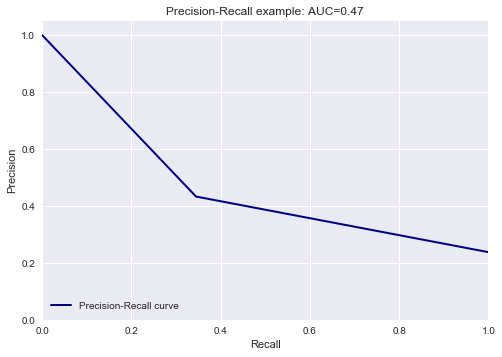

In [86]:
plot_precision_recall(y_val,y_pred_rf)

### Naive Bayes

In [87]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_trn,y_trn)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [88]:
cross_val_score(bnb, X_trn, y_trn.values.ravel().T, cv=cv).mean()

0.79399399399399406

In [89]:
y_pred_bnb = bnb.predict(X_val)
print(metrics.classification_report(y_val, y_pred_bnb))
print('BNB accuracy %s' % metrics.accuracy_score(y_val, y_pred_bnb))
print('BNB precision %s' % metrics.precision_score(y_val, y_pred_bnb))
print('BNB recall %s' % metrics.recall_score(y_val, y_pred_bnb))
print('BNB f1 score %s' % metrics.f1_score(y_val, y_pred_bnb))

             precision    recall  f1-score   support

        0.0       0.81      0.97      0.88      6207
        1.0       0.72      0.27      0.39      1934

avg / total       0.79      0.80      0.76      8141

BNB accuracy 0.800884412234
BNB precision 0.716459197787
BNB recall 0.267838676319
BNB f1 score 0.389913436206


In [90]:
plot_confusion_matrix(y_val,y_pred_bnb)

Confusion Matrix
###################
Predicted  <=50K  >50K
Actual                
<=50K       6002   205
>50K        1416   518
###################


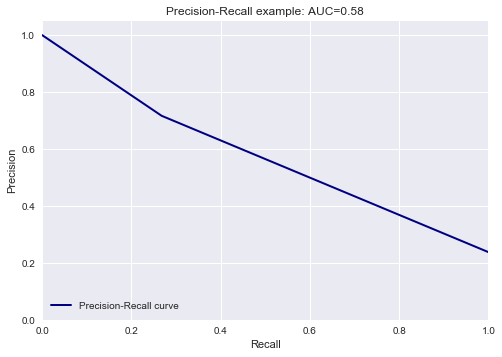

In [91]:
plot_precision_recall(y_val,y_pred_bnb)

### Naive Bayes with minmax scaled data

In [93]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_std,y_trn)
cross_val_score(bnb, X_std, y_trn.values.ravel().T, cv=cv).mean()

0.79407589407589407

In [94]:
y_pred_bnb = bnb.predict(X_std_val)
print(metrics.classification_report(y_val, y_pred_bnb))
print('GNB accuracy %s' % metrics.accuracy_score(y_val, y_pred_bnb))
print('GNB precision %s' % metrics.precision_score(y_val, y_pred_bnb))
print('GNB recall %s' % metrics.recall_score(y_val, y_pred_bnb))
print('GNB f1 score %s' % metrics.f1_score(y_val, y_pred_bnb))

             precision    recall  f1-score   support

        0.0       0.81      0.97      0.88      6207
        1.0       0.72      0.27      0.39      1934

avg / total       0.79      0.80      0.76      8141

GNB accuracy 0.800884412234
GNB precision 0.716459197787
GNB recall 0.267838676319
GNB f1 score 0.389913436206


In [95]:
plot_confusion_matrix(y_val,y_pred_bnb)

Confusion Matrix
###################
Predicted  <=50K  >50K
Actual                
<=50K       6002   205
>50K        1416   518
###################


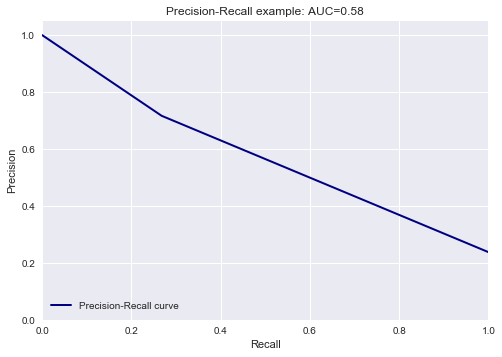

In [96]:
plot_precision_recall(y_val,y_pred_bnb)

### Naive Bayes with standard scaled data

In [97]:
from sklearn.naive_bayes import BernoulliNB

bnb =  BernoulliNB()
bnb.fit(X_trn_std,y_trn)

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
cross_val_score(bnb, X_trn_std, y_trn.values.ravel().T, cv=cv).mean()

0.80483210483210477

In [98]:
y_pred_bnb = bnb.predict(X_val_std)
print(metrics.classification_report(y_val, y_pred_bnb))
print('BNB accuracy %s' % metrics.accuracy_score(y_val, y_pred_bnb))
print('BNB precision %s' % metrics.precision_score(y_val, y_pred_bnb))
print('BNB recall %s' % metrics.recall_score(y_val, y_pred_bnb))
print('BNB f1 score %s' % metrics.f1_score(y_val, y_pred_bnb))

             precision    recall  f1-score   support

        0.0       0.87      0.87      0.87      6207
        1.0       0.59      0.60      0.59      1934

avg / total       0.81      0.81      0.81      8141

BNB accuracy 0.805306473406
BNB precision 0.588894549159
BNB recall 0.597724922441
BNB f1 score 0.593276879651


In [99]:
plot_confusion_matrix(y_val, y_pred_bnb)

Confusion Matrix
###################
Predicted  <=50K  >50K
Actual                
<=50K       5400   807
>50K         778  1156
###################


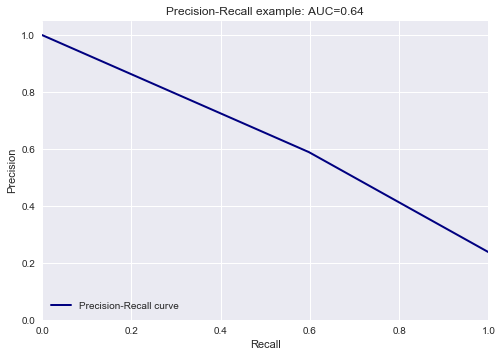

In [101]:
plot_precision_recall(y_val,y_pred_bnb)